In [100]:
%matplotlib inline
import torch
import random
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.model_selection import train_test_split
from scipy.interpolate import CubicSpline      
from transforms3d.axangles import axangle2mat  



data = sio.loadmat('./SBSB_6Khz_L23Mat_accZY_chunk_noTurn_noStatic.mat')


class AccZDataset(Dataset):
    def __init__(self,start_no,range_len):
        data = sio.loadmat('./SBSB_6Khz_L23Mat_accZY_chunk_noTurn_noStatic.mat')
        self.start_no = start_no
        self.range_len = range_len
        self.data_set = data['L23MatChunk']
        self.n_trails = len(self.data_set)
        self.train_set = np.zeros((1,50000))
        
        for i in range (0,self.n_trails):
            curr = np.asarray(self.data_set[i][0][0][self.start_no : self.start_no+self.range_len]).reshape(1,self.range_len)
            self.train_set = np.append(self.train_set, curr, axis = 0)

        self.train_set = np.delete(self.train_set, (0), axis=0) #array of 20 * 50000
        
        labels = []
        for i in range(0, self.n_trails):
            if(i < 10):
                labels.append(0)
            else:
                labels.append(1)
        
        labels = np.asarray(labels).reshape(self.n_trails,1)
        self.train_set = np.append(self.train_set, labels, axis = 1)
        print(self.train_set.shape)
    def __len__(self):
        return len(self.train_set)

    def __getitem__(self, idx):
        
        sample = self.train_set[idx][:-1]
        label = self.train_set[idx][-1]

        return sample, label 



dataset = AccZDataset(20,50000)
real_value, real_label = dataset[13]
print(real_value)
print(real_value.shape)
print(real_label)




(20, 50001)
[0.04913539 0.0478669  0.05771144 ... 0.16863332 0.05331072 0.04423187]
(50000,)
1.0


# DATASET PREPARATION FOR TRAINING DATASET

In [102]:
#DATASET PREPERATION


data = sio.loadmat('./SBSB_6Khz_L23Mat_accZY_chunk_noTurn_noStatic.mat')
start_no = 0
range_len = 50000
data_set = data['L23MatChunk']
n_trials = len(data_set)
total_set = np.zeros((1,50000))

for i in range (20):

    curr = np.asarray(data_set[i][0][0][start_no : start_no+range_len]).reshape(1,range_len)
    total_set = np.append(total_set, curr, axis = 0)

total_set = np.delete(total_set, (0), axis=0) 

labels = []
for i in range(0, n_trials):
    if(i < 10):
        labels.append(0)
    else:
        labels.append(1)

labels = np.asarray(labels).reshape(n_trials,1)
total_set = np.append(total_set, labels, axis = 1)
targets_numpy = total_set[:,-1]
features_numpy = total_set[:,:-1]
print("Features numpy {}".format(features_numpy.shape))
print("Targets numpy {}".format(targets_numpy.shape))

Features numpy (20, 50000)
Targets numpy (20,)


## DATASET PREPARATION FOR TESTING DATASET

In [109]:
vw_data = sio.loadmat('./VWVW_6Khz_L23Mat_accZY_chunk_noTurn_noStatic.mat')
vw_start_no = 0
vw_range_len = 50000
vw_data_set = data['L23MatChunk']
vw_n_trials = len(data_set)
vw_total_set = np.zeros((1,50000))

for i in range (20):

    vw_curr = np.asarray(vw_data_set[i][0][0][vw_start_no : vw_start_no + vw_range_len]).reshape(1,vw_range_len)
    vw_total_set = np.append(vw_total_set, vw_curr, axis = 0)

vw_total_set = np.delete(vw_total_set, (0), axis=0) 

vw_labels = []
for i in range(0, vw_n_trials):
    if(i < 10):
        vw_labels.append(0)
    else:
        vw_labels.append(1)

vw_labels = np.asarray(vw_labels).reshape(vw_n_trials,1)
vw_total_set = np.append(vw_total_set, vw_labels, axis = 1)

vw_total_set = np.append(vw_total_set, vw_total_set[0,:].reshape(1,-1), axis = 0)
vw_targets_numpy = vw_total_set[:,-1]
vw_features_numpy = vw_total_set[:,:-1]
print("Features numpy {}".format(vw_features_numpy.shape))
print("Targets numpy {}".format(vw_targets_numpy.shape))

Features numpy (21, 50000)
Targets numpy (21,)


# data augmentation for testing dataset

In [110]:
def GenerateRandomCurves(X, sigma=0.2, knot=4):
    xx = (np.ones((X.shape[1],1))*(np.arange(0,X.shape[0], (X.shape[0]-1)/(knot+1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    cs_x = CubicSpline(xx[:,0], yy[:,0])
    cs_y = CubicSpline(xx[:,1], yy[:,1])
    cs_z = CubicSpline(xx[:,2], yy[:,2])
    return np.array([cs_x(x_range),cs_y(x_range),cs_z(x_range)]).transpose()

In [111]:
sigma = 0.3
knot = 4

In [112]:
def DistortTimesteps(X, sigma=0.2):
    tt = GenerateRandomCurves(X, sigma) # Regard these samples aroun 1 as time intervals
    tt_cum = np.cumsum(tt, axis=0)        # Add intervals to make a cumulative graph
    # Make the last value to have X.shape[0]
    t_scale = [(X.shape[0]-1)/tt_cum[-1,0],(X.shape[0]-1)/tt_cum[-1,1],(X.shape[0]-1)/tt_cum[-1,2]]
    tt_cum[:,0] = tt_cum[:,0]*t_scale[0]
    tt_cum[:,1] = tt_cum[:,1]*t_scale[1]
    tt_cum[:,2] = tt_cum[:,2]*t_scale[2]
    return tt_cum

In [113]:
def DA_TimeWarp(X, sigma=0.2):
    tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    X_new[:,0] = np.interp(x_range, tt_new[:,0], X[:,0])
    X_new[:,1] = np.interp(x_range, tt_new[:,1], X[:,1])
    X_new[:,2] = np.interp(x_range, tt_new[:,2], X[:,2])
    return X_new

In [114]:
#implementation of time warping
vw_features_numpy_new = vw_features_numpy.T
vw_features_numpy_test = vw_features_numpy
vw_targets_numpy_test = vw_targets_numpy
n_sets_time_warping = 1


for j in range (n_sets_time_warping):
    for i in range(0,21,3):
        ip = vw_features_numpy_new[:,i:i+3]
        vw_features_numpy_test = np.append(vw_features_numpy_test, DA_TimeWarp(ip, sigma).T , axis = 0)
    vw_targets_numpy_test = np.append(vw_targets_numpy_test, vw_targets_numpy_test[:], axis = 0)

vw_features_numpy = vw_features_numpy_test
vw_targets_numpy = vw_targets_numpy_test
print("Testing features shape {}".format(vw_features_numpy.shape))
print("testing targets shape {}".format(vw_targets_numpy.shape))
    

Testing features shape (42, 50000)
testing targets shape (42,)


## data augmentation for training dataset

In [116]:
#DATA AUGMENTATION
#SINGLE KERNEL 

from scipy.interpolate import CubicSpline

features_numpy_new = features_numpy.T

print('Original FeaturesNumpy Database')
print(features_numpy.shape)
print('Original TargetsNumpy Database')
print(targets_numpy.shape)


#perform jittering
def DA_Jitter(X, sigma= 0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise

#perform scaling
def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

#perform magnitude warping 
def GenerateRandomCurves(X, sigma=0.2, knot=4):
    xx = (np.ones((X.shape[1],1))*(np.arange(0,X.shape[0], (X.shape[0]-1)/(knot+1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    cs_x = CubicSpline(xx[:,0], yy[:,0])
    return np.array([cs_x(x_range)]).transpose()

def DA_MagWarp(X, sigma):
    return X * GenerateRandomCurves(X, sigma)

#performing Rotation
percent_value = 1
percent_shift = (range_len / 100) * percent_value
def DA_Rotation(X):
    shift = np.random.randint(low=0 , high = percent_shift) #giving percent_value shift (if percent_value is 1, then 1% shift)
    return np.roll(X, shift)




#implement jittering
n_sets_jitter = 22
sigma = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,0.5,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,0.31,0.57]
#number of values in sigma list should match the n_sets_jitter value
for j in range (n_sets_jitter):
    for i in range(20):
        features_numpy = np.append(features_numpy, DA_Jitter(features_numpy_new[:,i], sigma[j]).reshape(1,-1), axis = 0)
    targets_numpy = np.append(targets_numpy, targets_numpy[0:20], axis = 0)



print('FeaturesNumpy Output shape after jittering')
print(features_numpy.shape)
print('TargetsNumpy Output shape after jittering')
print(targets_numpy.shape)

# #implement scaling
# features_numpy_new = features_numpy.T
# n_sets_scaling = 22
# sigma = [0.2,0.5,0.3,0.4,0.2,0.6,0.8,0.9,0.1,0.7,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,0.31,0.57,0.73]


# for j in range (n_sets_scaling):
#     for i in range(20):
#         features_numpy = np.append(features_numpy, DA_Scaling(features_numpy_new[:,0].reshape(-1,1), sigma[j]).reshape(1,-1), axis = 0)
#     targets_numpy = np.append(targets_numpy, targets_numpy[0:20], axis = 0)
    

# print('FeaturesNumpy Output shape after scaling')
# print(features_numpy.shape)
# print('TargetsNumpy Output shape after scaling')
# print(targets_numpy.shape)


#implement magnitude warping
features_numpy_new = features_numpy.T
n_sets_magwarp = 22
sigma = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,0.5,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,0.31,0.57]
#number of values in sigma list should match the n_sets_jitter value
for j in range (n_sets_magwarp):
    for i in range(20):
        features_numpy = np.append(features_numpy, DA_MagWarp(features_numpy_new[:,i].reshape(-1,1), sigma[j]).reshape(1,-1), axis = 0)
    targets_numpy = np.append(targets_numpy, targets_numpy[0:20], axis = 0)



print('FeaturesNumpy Output shape after magwarping')
print(features_numpy.shape)
print('TargetsNumpy Output shape after magwarping')
print(targets_numpy.shape)

#implement Rotation
features_numpy_new = features_numpy.T
n_sets_rotation = 22


print(DA_Rotation(features_numpy_new[:,i].reshape(-1,1)).reshape(1,-1))

for j in range (n_sets_rotation):
    for i in range(20):
        features_numpy = np.append(features_numpy, DA_Rotation(features_numpy_new[:,i].reshape(-1,1)).reshape(1,-1), axis = 0)
    targets_numpy = np.append(targets_numpy, targets_numpy[0:20], axis = 0)


print('FeaturesNumpy Output shape after rotation')
print(features_numpy.shape)
print('TargetsNumpy Output shape after rotation')
print(targets_numpy.shape)


Original FeaturesNumpy Database
(20, 50000)
Original TargetsNumpy Database
(20,)
FeaturesNumpy Output shape after jittering
(460, 50000)
TargetsNumpy Output shape after jittering
(460,)
FeaturesNumpy Output shape after magwarping
(900, 50000)
TargetsNumpy Output shape after magwarping
(900,)
[[2.08410195 2.09936471 2.10844982 ... 2.09845144 2.082688   2.07406994]]
FeaturesNumpy Output shape after rotation
(1340, 50000)
TargetsNumpy Output shape after rotation
(1340,)


## DATASET PREPARATION FOR TRAINING SET

In [155]:
#TRAIN AND TEST SPLIT


features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42)



featuresTrain = torch.from_numpy(features_train).type(torch.FloatTensor)
targetsTrain = torch.from_numpy(targets_train).type(torch.FloatTensor)

featuresTest = torch.from_numpy(features_test).type(torch.FloatTensor)
targetsTest = torch.from_numpy(targets_test).type(torch.FloatTensor)


train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)



batch_size = 16
batch_size_val = 4

train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
val_loader = torch.utils.data.DataLoader(test, batch_size = batch_size_val, shuffle = False)


print("Training dataset dimensions")
print('Shape of Features Train Dataset')
print(featuresTrain.size())
print('Shape of Targets Train Dataset')
print(targetsTrain.size())
print('Shape of Features Test Dataset')
print(featuresTest.size())
print('Shape of Targets Test Dataset')
print(targetsTest.size())

Training dataset dimensions
Shape of Features Train Dataset
torch.Size([1072, 50000])
Shape of Targets Train Dataset
torch.Size([1072])
Shape of Features Test Dataset
torch.Size([268, 50000])
Shape of Targets Test Dataset
torch.Size([268])


## DATASET PREPARATION FOR TESTING DATASET

In [156]:
print("Dimensions before preparation")
print("features dataset shape {}".format(vw_features_numpy.shape))
print("Targets dataset shape {}".format(vw_targets_numpy.shape))

Dimensions before preparation
features dataset shape (42, 50000)
Targets dataset shape (42,)


In [157]:
vw_features = torch.from_numpy(vw_features_numpy).type(torch.FloatTensor)
vw_targets = torch.from_numpy(vw_targets_numpy).type(torch.FloatTensor)

vw_totalDataset = torch.utils.data.TensorDataset(vw_features,vw_targets)

batch_size_test = 3
vw_test_loader = torch.utils.data.DataLoader(vw_totalDataset, batch_size = batch_size_test, shuffle = False)


print('Testing dataset dimensions')
print('Shape of Features Dataset')
print(vw_features.size())
print('Shape of Targets Dataset')
print(vw_targets.size())

Testing dataset dimensions
Shape of Features Dataset
torch.Size([42, 50000])
Shape of Targets Dataset
torch.Size([42])


In [158]:

#Designing the model

filters = 1

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels = 1, out_channels = filters,kernel_size=25, stride=10),
            nn.ReLU(),
            nn.BatchNorm1d(filters))
        self.layer2 = nn.Sequential(
            nn.Conv1d(in_channels = filters, out_channels = filters, kernel_size=10, stride=5),
            nn.ReLU(),
            nn.BatchNorm1d(filters))
        self.layer3 = nn.Sequential(
            nn.Conv1d(in_channels = filters, out_channels = filters, kernel_size=10, stride=3),
            nn.ReLU(),
            nn.BatchNorm1d(filters))
        self.avgLayer = nn.AvgPool1d(10, stride = 2)
        self.fc1 = nn.Linear(161,2)


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out) 
        out = self.avgLayer(out)
        out = self.fc1(out)
        return out

    def init_hidden(self,batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        return Variable(hidden)
    
    
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        torch.nn.init.xavier_uniform(m.weight.data, nn.init.calculate_gain('relu'))
        m.bias.data.zero_()
    

model = ConvNet()
optimizer = optim.SGD(model.parameters(), lr=0.2)
criterion = nn.CrossEntropyLoss()
model

ConvNet(
  (layer1): Sequential(
    (0): Conv1d(1, 1, kernel_size=(25,), stride=(10,))
    (1): ReLU()
    (2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1d(1, 1, kernel_size=(10,), stride=(5,))
    (1): ReLU()
    (2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Conv1d(1, 1, kernel_size=(10,), stride=(3,))
    (1): ReLU()
    (2): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (avgLayer): AvgPool1d(kernel_size=(10,), stride=(2,), padding=(0,))
  (fc1): Linear(in_features=161, out_features=2, bias=True)
)

/Users/saivineethks/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Current Epoch: 0


/Users/saivineethks/anaconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Iteration: 1  Loss: 0.04345880076289177  Accuracy: 97 %
Current Epoch: 1
Iteration: 2  Loss: 0.01681915670633316  Accuracy: 99 %
Current Epoch: 2
Iteration: 3  Loss: 0.009326040744781494  Accuracy: 99 %
Current Epoch: 3
Iteration: 4  Loss: 0.006502524018287659  Accuracy: 99 %
Current Epoch: 4
Iteration: 5  Loss: 0.005536682903766632  Accuracy: 99 %


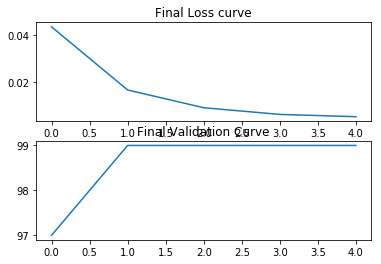

In [159]:
# #  training model 
model.apply(weights_init)
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
n_classes = 2
for epoch in range(num_epochs):
    print('Current Epoch: {}'.format(epoch))
    for i, (samples, targets) in enumerate(train_loader):
        
        train = Variable(samples.view(batch_size,1,-1))
        targets = Variable(targets.type(torch.LongTensor))
        

        # Clear gradients
        optimizer.zero_grad()
        
        #setting up model for training
        model.train()
        
        # Forward propagation
        outputs = model(train)
        outputs = outputs.reshape(batch_size,2)
        # Calculate softmax and cross entropy loss
        loss = criterion(outputs, targets)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
    count += 1
    #accuracy at the end of epoch    
    correct = 0
    total = 0
    # Predict test dataset
    for samples, labels in val_loader:

        test = Variable(samples.view(batch_size_val,1,-1))

        #setting up in test mode
        model.eval()
        # Forward propagation
        outputs = model(test)
        outputs = outputs.view(batch_size_val, n_classes)

        # Get predictions from the maximum value
        predicted = torch.max(outputs.data, 1)[1].type(torch.FloatTensor)

        # Total number of labels
        total += len(labels)

        # Total correct predictions
        correct += (predicted == labels).sum()

    accuracy = 100 * correct / float(total)

    loss_list.append(loss.data)
    iteration_list.append(count)
    accuracy_list.append(accuracy)
    

    print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data[0], accuracy))

plt.subplot(2,1,1)
plt.title('Final Loss curve')
plt.plot(loss_list)
plt.subplot(2,1,2)
plt.title('Final Validation Curve')
plt.plot(accuracy_list)

In [164]:


from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


accuracy_list = []
f1_score_list = []
precision_list = []
recall_list = []
y_pred =[]
y_true = []

batch_size_val = 16
with torch.no_grad():
    for i, data in enumerate(vw_test_loader, 0):
            samples, labels = data
            samples = Variable(samples.view(batch_size_test,1,-1))
            
            model.eval()
            
            outputs = model(samples)
            outputs = outputs.view(batch_size_test, n_classes)
            
            predictions = torch.argmax(outputs, 1)
            targets = labels
            
            y_pred.extend(predictions)
            y_true.extend(targets)



conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)
print("Accuracy Score: {}".format(accuracy_score(y_true, y_pred) * 100))
print("F1 Score: {}". format(f1_score(y_true, y_pred) * 100))
print("Precision Score: {}".format(precision_score(y_true, y_pred) * 100))
print("Recall Score: {}".format(recall_score(y_true, y_pred)* 100))
            
            


[[18  4]
 [ 2 18]]
Accuracy Score: 85.71428571428571
F1 Score: 85.71428571428572
Precision Score: 81.81818181818183
Recall Score: 90.0


In [11]:
from sklearn.metrics import confusion_matrix
output = torch.randn(1, 2, 4, 4)
pred = torch.argmax(output, 1)
print(pred)
target = torch.empty(1, 4, 4, dtype=torch.long).random_(2)
print(target)
confusion_matrix(pred.view(-1), target.view(-1))

tensor([[[1, 0, 0, 1],
         [0, 0, 1, 1],
         [0, 0, 0, 0],
         [1, 0, 1, 1]]])
tensor([[[0, 1, 1, 0],
         [0, 0, 1, 0],
         [0, 0, 1, 1],
         [1, 0, 1, 0]]])


array([[5, 4],
       [4, 3]])